# Reference level cross validation
In scenarios where you have no prior knowledge of the elevation of the density contrast of interest, we use a flat starting model with an arbitrary reference level. The reference level (`zref`) is very important to the inversion as different value can vertically shift the inverted topography. Here we present a cross-validation approach to determine the optimal value for `zref`. This follows the same approach as the past notebook (`density_cross_validation.ipynb`). To simplify, we assume we know the appropiate density constrast value to use. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2


import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import maps
from antarctic_plots import utils as ap_utils

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

/home/matt/invert4geom/src/invert4geom/cross_validation.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Create observed gravity data

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Constraint points

Sample the starting topography at 10 random locations to create a set of constraints points, simulating locations where the topography is known.

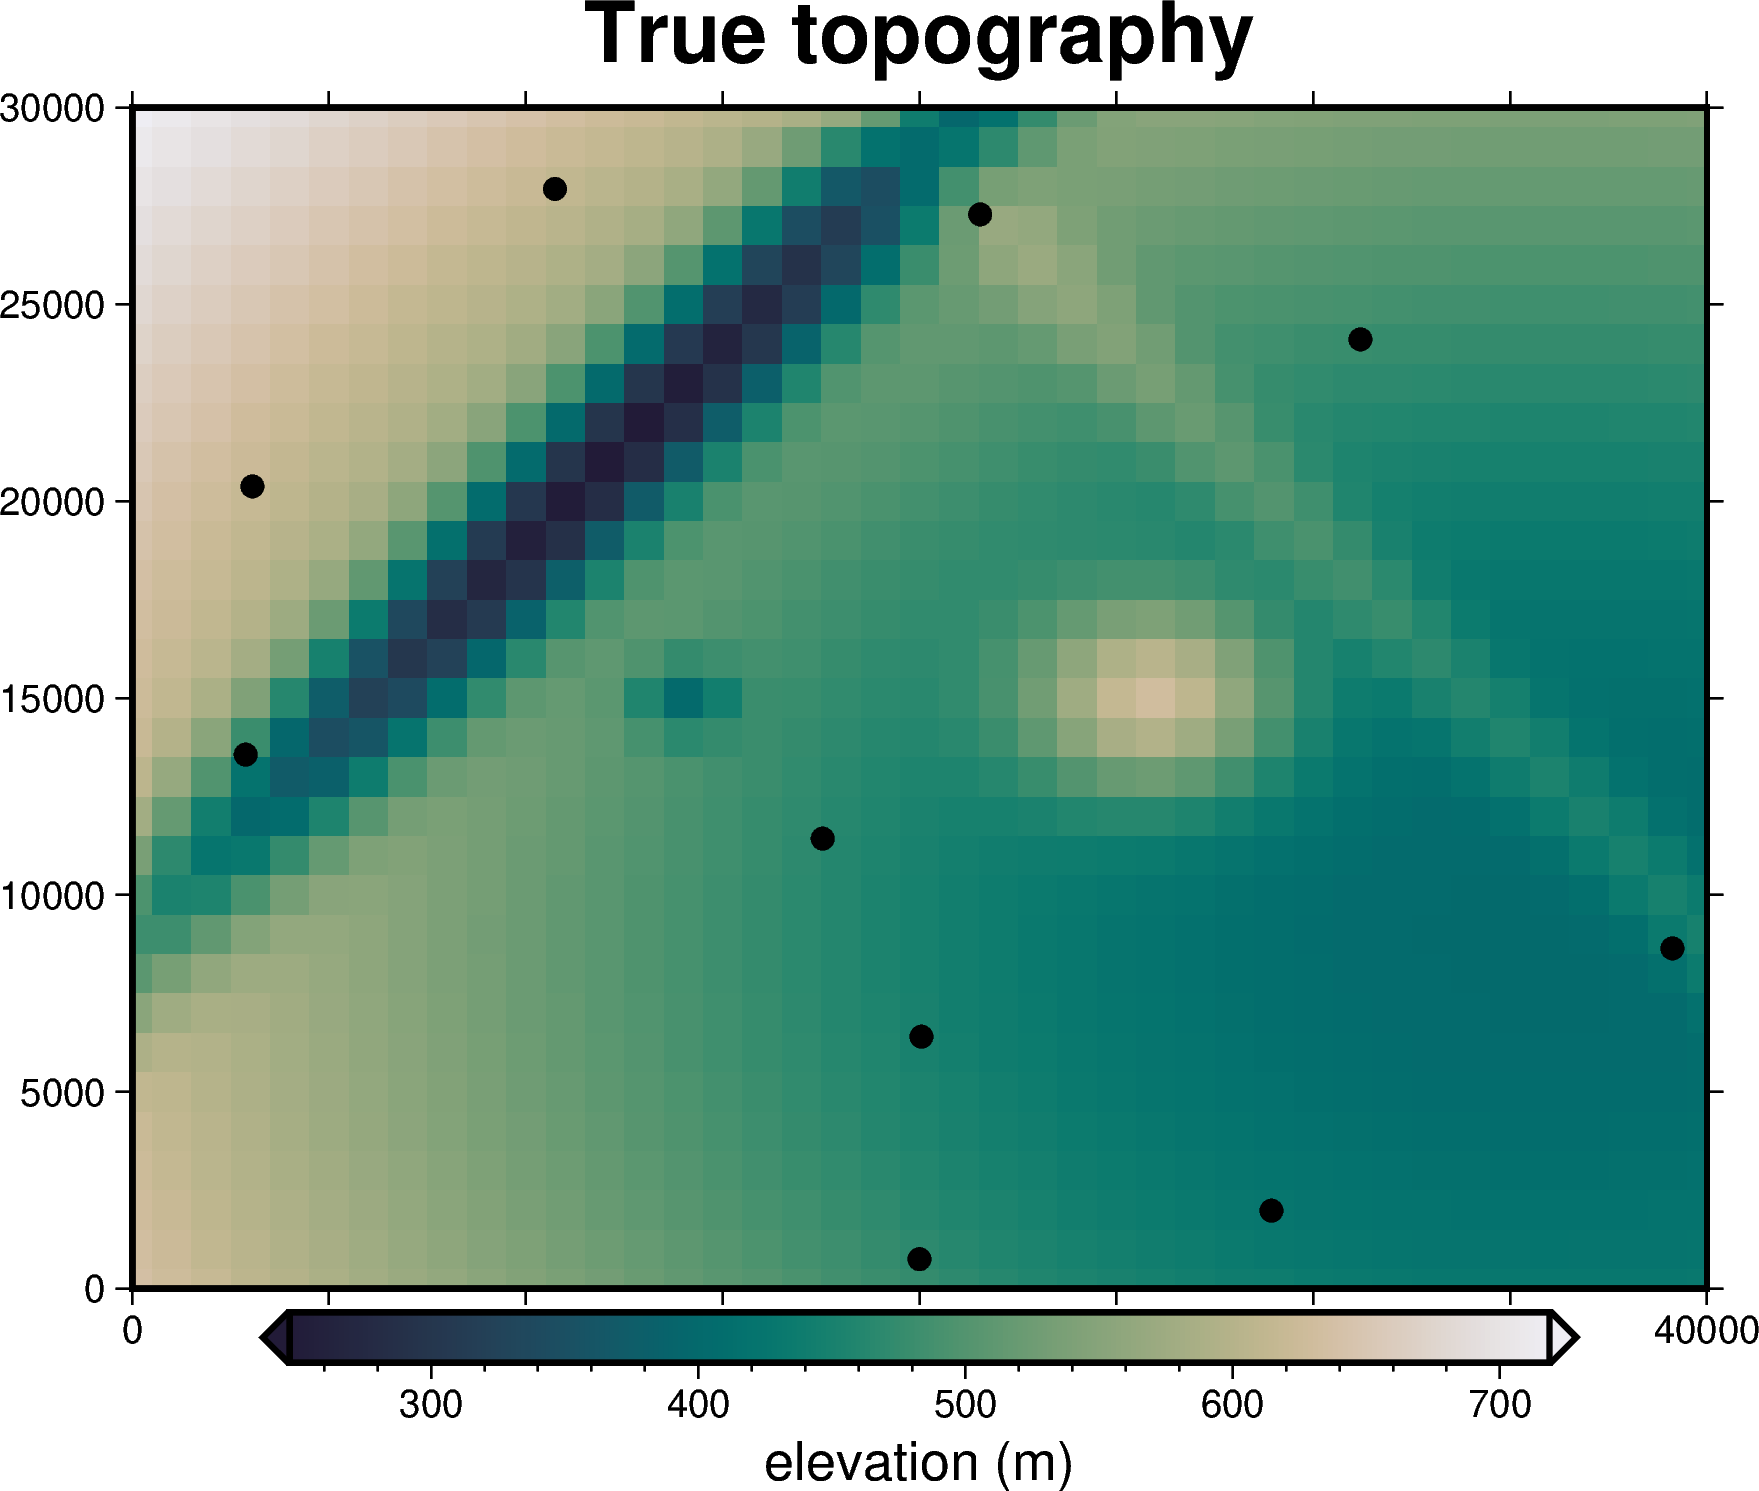

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)
fig.show()

### True topogrpahy prism layer

In [4]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()
print(f"mean of true topography: {zref} m ")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

mean of true topography: 492.2704164812973 m 


### Forward gravity of prism layer

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


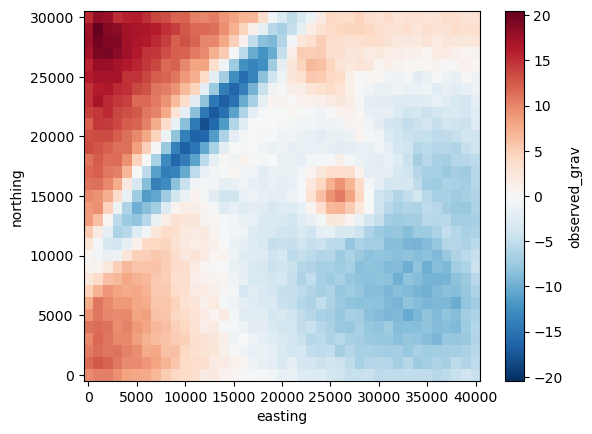

In [6]:
# contaminate gravity with 1 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

For simplicity here we assume that we know the optimal density contrast value and use this when creating our starting model.

What we don't know in this scenario is what reference elevation `zref` to use. We will use a cross-validation of a range of elevations to find the one which is optimal.

Each `zref` will give a cross validation score, and the lowest score will show which `zref` is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points, same as in the past nootebook. 

## Get Cross Validation Score

First we need to use the `zref` value to create the starting model. We will then use this in an inversion to calculate a `score`.

In [7]:
# set a zref value
zref = 300  # instead of the correct value of ~490 m

# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]
grav_df["reg"] = 0
grav_df["res"] = grav_df.misfit

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "solver_damping": 0.1,
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score
score = cross_validation.constraints_cv_score(
    grav=grav_df,
    constraints=constraint_points,
    **kwargs,
)
score

194.8080323346519

## Cross Validation
Let se if we can improve the score with other values for `zref`. 

Now we can repeat this with a range of `zref` values to find the optimal (lowest) score. But remember we need to recreate the starting model with each `zref`.

In [8]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set which zref values to include
zrefs = np.linspace(400, 600, 8)

# run inversions and collect scores
scores = []
for zref in zrefs:
    # create flat topography grid with a constant height
    starting_topography = xr.full_like(true_topography, zref)

    # re-calculate density grid with new density contrast
    density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_topography,
        zref,
        density=density,
    )

    # update zref value in kwargs
    kwargs["zref"] = zref

    # update starting model in kwargs
    kwargs["prism_layer"] = starting_prisms

    # run cross validation
    score = cross_validation.constraints_cv_score(
        grav=grav_df,
        constraints=constraint_points,
        **kwargs,
    )
    scores.append(score)

# print zref and score pairs
for zref, score in zip(zrefs, scores):
    print(f"Reference level: {zref} -> Score: {score}")

best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_zref = zrefs[best_idx]
print(f"Best score of {best_score} with reference level={best_zref}")

Reference level: 400.0 -> Score: 95.28058460003426
Reference level: 428.57142857142856 -> Score: 66.79420158764773
Reference level: 457.14285714285717 -> Score: 38.39424789324149
Reference level: 485.7142857142857 -> Score: 10.840430866668894
Reference level: 514.2857142857143 -> Score: 19.748427566026876
Reference level: 542.8571428571429 -> Score: 47.84885673118
Reference level: 571.4285714285714 -> Score: 76.26691479957566
Reference level: 600.0 -> Score: 104.7602426080746
Best score of 10.840430866668894 with reference level=485.7142857142857


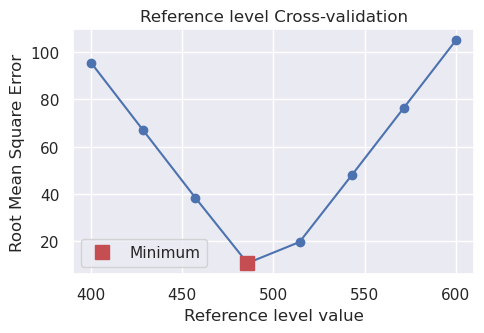

In [9]:
plotting.plot_cv_scores(
    scores,
    zrefs,
    param_name="Reference level",
    # logx=True,
    # logy=True,
)

## Run inversion with optimal value

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -5.8638 m, RMSE:33.4603 m
INFO:root:updated misfit RMSE: 4.1037
INFO:root:updated L2-norm: 2.0258, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3203, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 12.4942 m, RMSE:18.7286 m
INFO:root:updated misfit RMSE: 2.4567
INFO:root:updated L2-norm: 1.5674, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2924, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 6.9882 m, RMSE:10.8116 m
INFO:root:updated misfit RMSE: 1.5601
INFO:root:updated L2-norm: 1.249, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2549, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 4.0601 m, RMSE:6.5

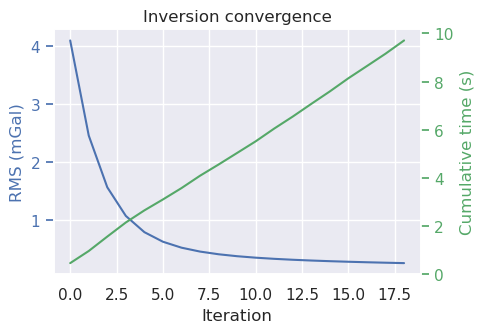

In [10]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# use the best zref value
zref = best_zref

# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# re-calculate density grid with the best zref
density = xr.where(
    starting_topography >= zref,
    kwargs.get("density_contrast"),
    -kwargs.get("density_contrast"),
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# update starting model in kwargs
kwargs["prism_layer"] = starting_prisms

# make new kwargs without zref or density
new_kwargs = {
    key: value
    for key, value in kwargs.items()
    if key
    not in [
        "zref",
        "density_contrast",
    ]
}
results = inversion.run_inversion(
    input_grav=grav_df,
    plot_convergence=True,
    zref=zref,
    density_contrast=kwargs.get("density_contrast"),
    **new_kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


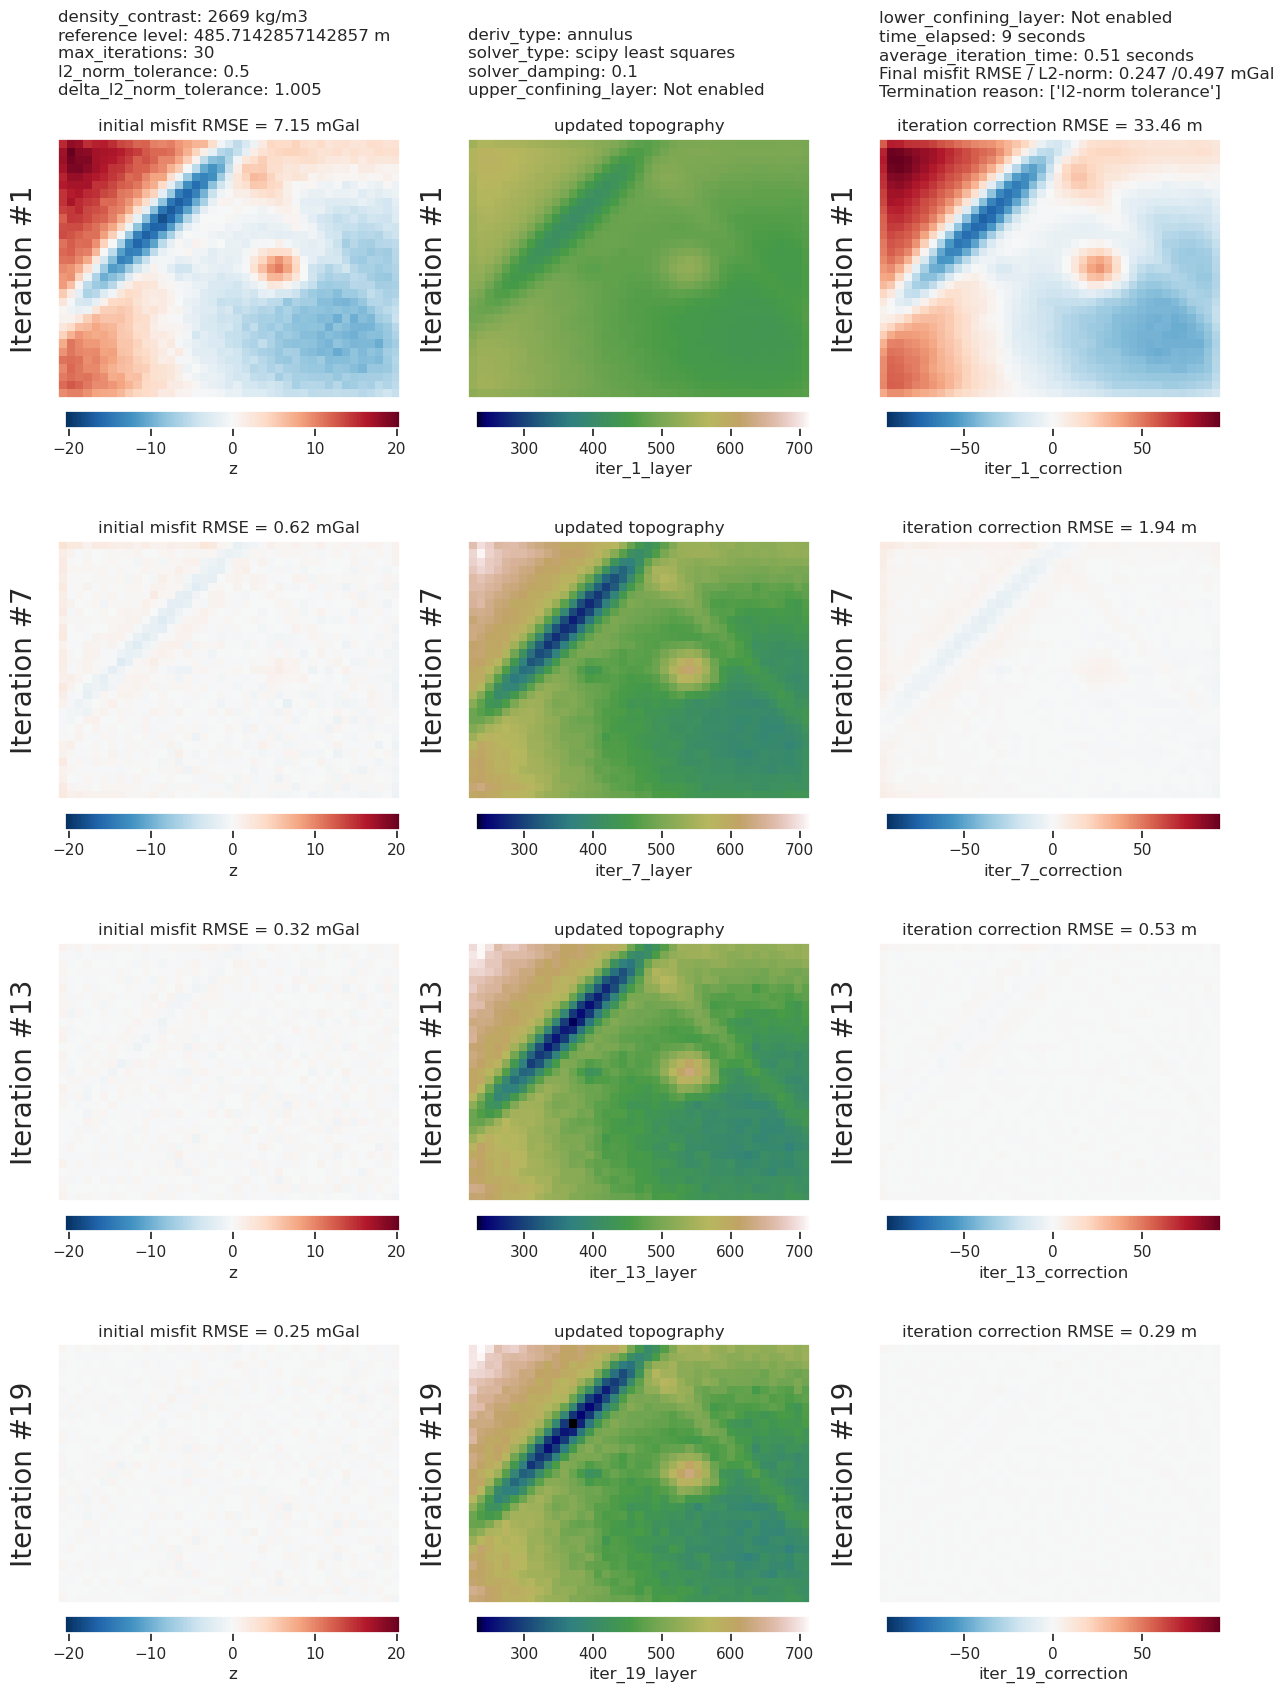

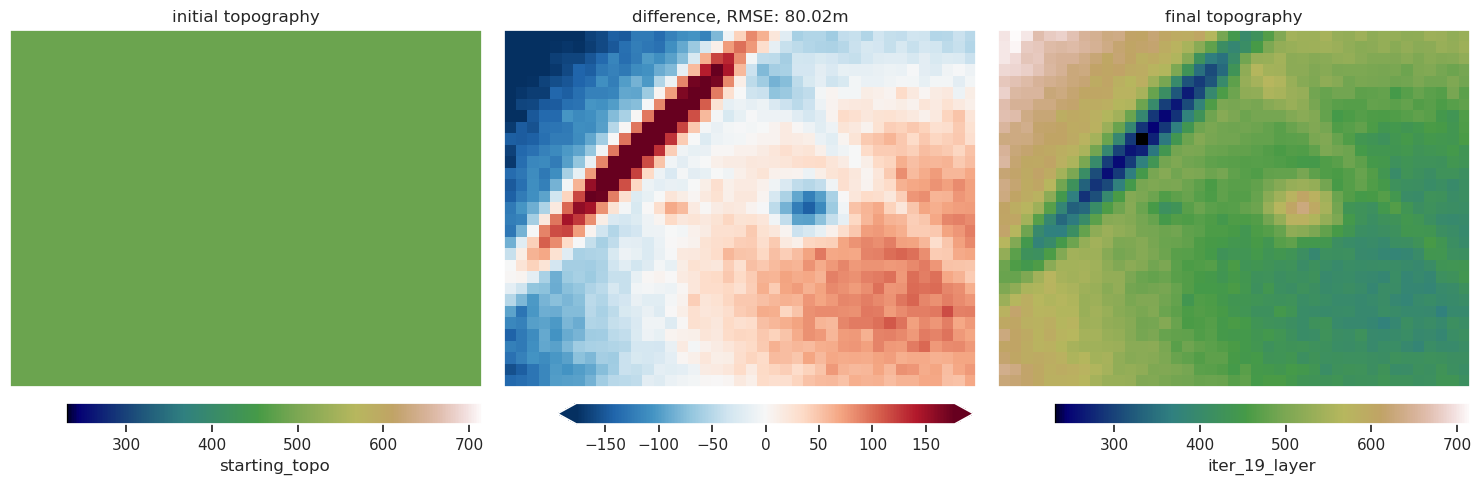

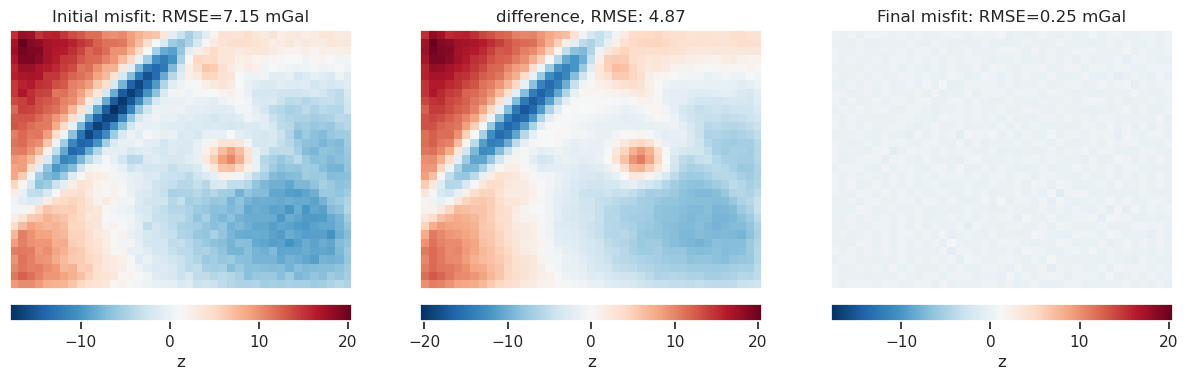

In [11]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


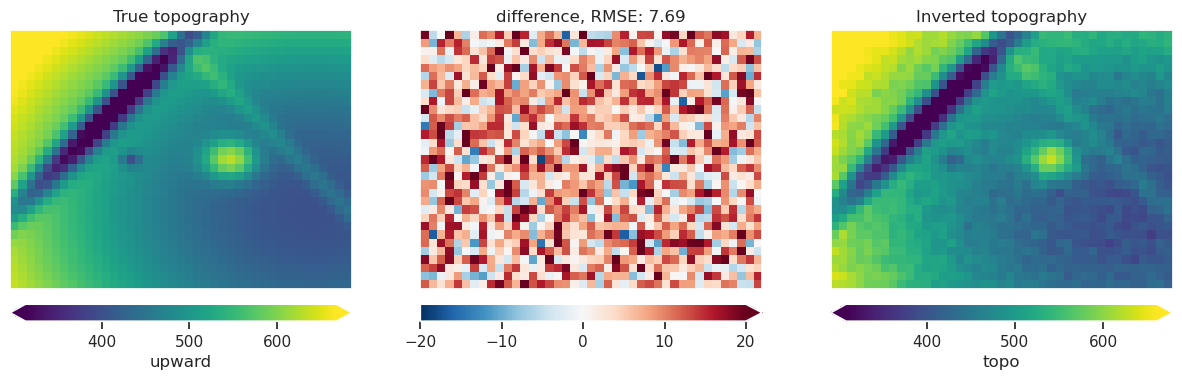

In [12]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
)

#